In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report

import re

In [2]:
# Load data
emails = pd.read_csv('data/train.csv')

In [3]:
# Check shape
print(f'There are {emails.shape[0]} rows in the '
      f'dataset and {emails.shape[1]} columns.')

There are 8348 rows in the dataset and 4 columns.


In [4]:
# Check for duplicates
unique_PIDs = len(emails['id'].unique())
total_PIDs = emails.shape[0]
number_of_dupes = total_PIDs - unique_PIDs
print(f'There are {number_of_dupes} duplicates in the dataset.')

There are 0 duplicates in the dataset.


In [5]:
# Train test split, seeded for replication
train, test = train_test_split(emails, test_size=0.1, random_state=1)

In [6]:
# Check for missing values
train.isna().sum().sort_values(ascending=False)

subject    6
spam       0
email      0
id         0
dtype: int64

In [7]:
# Class imbalance?
train['spam'].replace({0: 'Ham', 1: 'Spam'}).value_counts() * 100 / len(train)

Ham     74.63064
Spam    25.36936
Name: spam, dtype: float64

In [8]:
# Some emails have NaNs for their subjects
def handle_missing_data(data):
    data = data.fillna('')
    return data

In [9]:
def frac_upper(string):
    """Computes the fraction of alphabetical characters
    in STRING that are uppercase. If no alphabetical
    characters, returns 0."""
    num_upper = len(re.findall(r'[A-Z]', string))
    num_letters = len(re.findall(r'[a-zA-Z]', string))
    if num_letters == 0:
        return 0
    else:
        return num_upper / num_letters
    
def number_of(regex):
    """Returns a lambda that when applied to a string
    will count the number of occurences of REGEX in the
    string (for use in making new features below)."""
    return lambda string: len(re.findall(regex, string))

In [10]:
def make_new_features(data):
    # Combine subject and email columns
    data['combined'] = data['subject'] + ' ' + data['email']

    # Make everything in 'combined' lowercase and remove punctuation
    data['no_punc'] = (
        data['combined']
        .str.lower()
        .str.replace(pat=r'[^\w\s]', repl=' ')
    )
    
    # Count number of characters, words, new line characters,
    # etc. Take logs of these. Also compute fraction of
    # uppercase letters in email
    data['log_chars'] = np.log1p(data['combined'].apply(len))
    data['log_words'] = np.log1p(data['no_punc'].apply(lambda string: len(string.split())))
    data['log_new_lines'] = np.log1p(data['combined'].apply(number_of(r'[\n]')))
    data['log_angle_brackets'] = np.log1p(data['combined'].apply(number_of(r'[<>]')))
    data['log_exclamations'] = np.log1p(data['combined'].apply(number_of(r'[!]')))
    data['log_punctuation'] = np.log1p(data['combined'].apply(number_of(r'[\n$%<>!?]')))
    data['frac_upper'] = data['combined'].apply(frac_upper)
    
    return data

In [11]:
# The following function runs only on 'train' so as to
# guarantee that, when we run our data through the pipeline,
# the same words are used for both 'train' and 'test'.
def spam_ham_words(min_emails, num_spam, num_ham):
    # Combine subject and email columns
    train['combined'] = train['subject'] + ' ' + train['email']
    
    # Make everything in 'combined' lowercase and remove punctuation
    train['no_punc'] = (
        train['combined']
        .str.lower()
        .str.replace(pat=r'[^\w\s]', repl=' ')
    )
    
    # Put email text into "tidy format", i.e., each word of each
    # email gets put into its own row, indexed by id of email
    tidy_format = (
        train['no_punc']
        .str.split(expand=True)
        .stack()
        .reset_index(level=1)
        .rename(columns={'level_1': 'num', 0: 'word'})
        # The following lines drop repeated words in same email
        # Not sure if should keep these
        .drop('num', axis=1)
        .reset_index()
        .drop_duplicates()
        .set_index('index')
    )
    
    # Find which words are most indicative of a spam email
    # versus a ham email. Limit to words appearing in at
    # least 'min_emails' emails
    words = (
        tidy_format
        .groupby('word')
        .filter(lambda x: x.index.nunique() >= min_emails)
        .merge(train[['spam']], how="left", left_index=True, right_index=True)
        .groupby('word')[['spam']]
        .mean()
        .sort_values('spam', ascending=False)
    )
    
    spam_words = words.index[:num_spam].tolist()
    ham_words = words.index[-num_ham:].tolist()
    
    words = spam_words + ham_words
    
    return words

def words_in_texts(words, texts):
    """Returns a dataframe the (i, j)^th entry of which is 1 
    if the i^th element of TEXTS contains the j^th element of
    WORDS as a substring and is 0 otherwise."""
    indicator_array = np.array([texts.str.contains(word).astype(int) for word in words]).T
    df = pd.DataFrame(indicator_array, columns=words)
    return df

In [12]:
def append_words_cols(data, words):
    """For each word in WORDS, appends a binary feature 
    indicating whether that word appears in a given email."""
    # Must reset index on 'data' for use in concat
    data = data.reset_index(drop=True)
    
    words_in_texts_df = words_in_texts(words, data['no_punc'])
    data = pd.concat([data, words_in_texts_df], axis=1)
    return data

In [13]:
# Drop unneeded columns
def drop_cols(data, cols):
    data = data.drop(cols, axis=1)
    return data

cols_to_drop = ['id', 'subject', 'email', 'combined', 'no_punc']
#cols_to_drop = ['id', 'subject', 'email', 'combined', 'no_punc', 'log_angle_brackets', 'log_exclamations']

# The graphs for 'log_angle_brackets' and 'log_exclamations'
# are strange. Not clear whether we should include these
# features. We'll try running the model with them and
# try it again without them.

In [14]:
# Put this in the for loop over all hyperparams
min_emails, num_spam, num_ham = (600, 90, 60)

words = spam_ham_words(min_emails, num_spam, num_ham)

/Users/efscerbo/anaconda3/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/efscerbo/anaconda3/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [15]:
def data_process_pipeline(data):
    data = (
        data
        .pipe(handle_missing_data)
        .pipe(make_new_features)
        .pipe(append_words_cols, words)
        .pipe(drop_cols, cols_to_drop)
    )
    
    return data

In [16]:
# Final dataframes before modeling. Rename 'spam' as
# 'Spam' bc one of the words found by 'spam_ham_words'
# is 'spam'
processed_train = data_process_pipeline(train.copy().rename(columns={'spam': 'Spam'}))
processed_test = data_process_pipeline(test.copy().rename(columns={'spam': 'Spam'}))

X_train = processed_train.drop('Spam', axis=1)
y_train = processed_train['Spam']
X_test = processed_test.drop('Spam', axis=1)
y_test = processed_test['Spam']

#### Consider using LogisticRegressionCV
#### Also, hyperparams to tweak: 'min_emails', 'num_spam', and 'num_ham' in 'spam_ham_words', as well as classification threshold in LogisticRegression model object. Also consider dropping the 'log_angle_brackets' and 'log_exclamations' cols.

In [17]:
model = LogisticRegression()
model.fit(X_train, y_train)

training_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)
print('Training Accuracy: ', training_accuracy)
print('Test Accuracy: ', test_accuracy)

Training Accuracy:  0.9801677093038733
Test Accuracy:  0.9640718562874252


In [18]:
# Trying different classification thresholds
for C in np.linspace(0.4, 0.75):
    y_pred_diff_thresh = 1*(model.predict_proba(X_test)[:, 1] > C)
    print(str(C) + ':', sum(y_pred_diff_thresh == y_test) / len(y_test))

0.4: 0.9652694610778443
0.40714285714285714: 0.9640718562874252
0.4142857142857143: 0.9640718562874252
0.42142857142857143: 0.9640718562874252
0.4285714285714286: 0.9640718562874252
0.4357142857142857: 0.9652694610778443
0.4428571428571429: 0.9652694610778443
0.45: 0.9676646706586827
0.4571428571428572: 0.9676646706586827
0.4642857142857143: 0.9664670658682635
0.4714285714285714: 0.9676646706586827
0.4785714285714286: 0.9676646706586827
0.48571428571428577: 0.9652694610778443
0.4928571428571429: 0.9652694610778443
0.5: 0.9640718562874252
0.5071428571428571: 0.9640718562874252
0.5142857142857143: 0.9640718562874252
0.5214285714285715: 0.9640718562874252
0.5285714285714286: 0.9640718562874252
0.5357142857142857: 0.9652694610778443
0.5428571428571429: 0.9664670658682635
0.55: 0.9664670658682635
0.5571428571428572: 0.9664670658682635
0.5642857142857143: 0.9664670658682635
0.5714285714285714: 0.9652694610778443
0.5785714285714286: 0.9640718562874252
0.5857142857142857: 0.962874251497006
0.5

In [ ]:
import itertools

min_emails_range = range(600, 1201, 100)
num_spam_range = range(30, 101, 15)
num_ham_range = range(30, 101, 15)

training_scores = {}
test_scores = {}

for triple in itertools.product(min_emails_range, num_spam_range, num_ham_range):
    print(triple)
    
    min_emails, num_spam, num_ham = triple
    
    words = spam_ham_words(min_emails, num_spam, num_ham)
    
    processed_train = data_process_pipeline(train.copy().rename(columns={'spam': 'Spam'}))
    processed_test = data_process_pipeline(test.copy().rename(columns={'spam': 'Spam'}))
    
    X_train = processed_train.drop('Spam', axis=1)
    y_train = processed_train['Spam']
    X_test = processed_test.drop('Spam', axis=1)
    y_test = processed_test['Spam']
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    training_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    
    training_scores[triple] = training_accuracy
    test_scores[triple] = test_accuracy

In [ ]:
max(test_scores, key=test_scores.get)

In [ ]:
max(training_scores, key=training_scores.get)

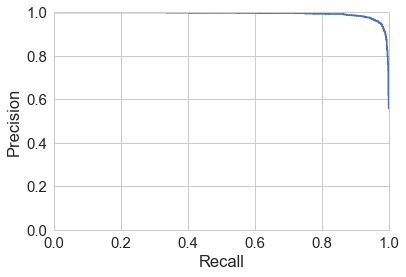

             precision    recall  f1-score   support

          0       0.97      0.98      0.98       601
          1       0.96      0.91      0.93       234

avg / total       0.96      0.96      0.96       835



In [19]:
y_predict = model.predict_proba(X_train)[:, 1]
prec, recall, _ = precision_recall_curve(y_train, y_predict)
plt.plot(recall, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

print(classification_report(y_test, model.predict(X_test)))

In [ ]:
from datetime import datetime

evaluation = pd.read_csv('data/eval.csv')
evaluation_predictions = model.predict(data_process_pipeline(evaluation.copy()))

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": evaluation['id'], 
    "Class": evaluation_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.isoformat(datetime.now()).split(".")[0]
submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)